In [1]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from keras.optimizers import SGD, Adam
from keras import regularizers
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
#from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

In [2]:
x = np.load('innorm-14minevents-ds10hz-filt1-4_2.5-13.6.npy') 
x.shape

(6993, 8192)

# Building the autoencoder

In [3]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
import keras.backend as K 

inp = Input(shape=( 8192, 1))  
e = Conv1D(11, 3, activation='tanh', padding='same')(inp)
#e = BatchNormalization()(e)
e = MaxPooling1D(2, padding='same')(e)

e = Conv1D(9, 3, activation='tanh', padding='same')(e)
#e = BatchNormalization()(e)
e = MaxPooling1D(2, padding='same')(e)

e = Conv1D(3, 3, activation='tanh', padding='same')(e)
e = MaxPooling1D(2, padding='same')(e)

e = Conv1D(3, 3, activation='tanh', padding='same')(e)
e = MaxPooling1D(2, padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d1 = Reshape([512,3])(encoded)

#encoded=e

d = Conv1D(3, 5, activation='tanh', padding='same')(d1)
d = UpSampling1D(2)(d)

d = Conv1D(3, 3, activation='tanh', padding='same')(d)
d = UpSampling1D(2)(d)

d = Conv1D(9, 3, activation='tanh', padding='same')(d)
d = UpSampling1D(2)(d)

d = Conv1D(11, 3, activation='tanh', padding='same')(d)
d = UpSampling1D(2)(d)

decoded = Conv1D(1, 3, padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#plot_model(autoencoder, to_file='autoencoder1D.png', show_shapes=True)
from IPython.display import Image, display
#Image(filename='autoencoder1D.png')
autoencoder.summary()

2022-08-02 15:40:20.800237: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8192, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8192, 11)          44        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4096, 11)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4096, 9)           306       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2048, 9)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2048, 3)           

# Pretraining of the autoencoder

In [4]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.fit(x, x, batch_size=128, epochs=50, callbacks=[csv_logger])

Epoch 1/50
55/55 [==============================] - 237s 550ms/step - loss: 1.0009
Epoch 2/50
55/55 [==============================] - 29s 523ms/step - loss: 0.9990
Epoch 3/50
55/55 [==============================] - 32s 592ms/step - loss: 0.9895
Epoch 4/50
55/55 [==============================] - 36s 658ms/step - loss: 0.9592
Epoch 5/50
55/55 [==============================] - 42s 761ms/step - loss: 0.9254
Epoch 6/50
55/55 [==============================] - 50s 909ms/step - loss: 0.8894
Epoch 7/50
55/55 [==============================] - 62s 1s/step - loss: 0.8587
Epoch 8/50
55/55 [==============================] - 40s 735ms/step - loss: 0.8324
Epoch 9/50
55/55 [==============================] - 97s 2s/step - loss: 0.8122
Epoch 10/50
55/55 [==============================] - 59s 1s/step - loss: 0.7972
Epoch 11/50
55/55 [==============================] - 52s 954ms/step - loss: 0.7846
Epoch 12/50
55/55 [==============================] - 58s 1s/step - loss: 0.7753
Epoch 13/50
55/55 [=====

In [5]:
decoder = Model(inputs=encoded, outputs=decoded, name='decoder')
encoded_imgs = encoder.predict(x)
decoded_imgs = decoder.predict(encoded_imgs)

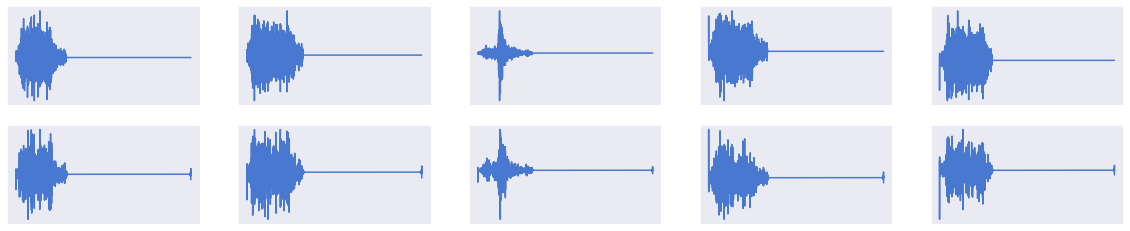

In [6]:
# Compare the input and output of the autoencoder


s=1
e=6
n = e-s
plt.figure(figsize=(20, 4))
for i in range(s,e):
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    #plt.imshow(x[i].reshape(28, 28))
    plt.plot(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    plt.plot(decoded_imgs[i])
    #plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Test DBSCAN 

In [270]:
# test DBSCAN clustering
# I think this is not a suitable method for our problem

from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=1.1, min_samples=2).fit(encoder.predict(x))
labels = dbscan.labels_
np.savetxt('DBSAN-labels.txt',  labels, fmt='%i', delimiter=',')

In [271]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 4233


In [272]:
dbscan.core_sample_indices_

array([ 100,  111,  113, ..., 6805, 6860, 6918])

# Guassian Mixture Models

In [275]:
# Gaussian Mixture Models

from sklearn import mixture
gmm = mixture.GaussianMixture (n_components=7, covariance_type='full').fit(encoder.predict(x))

labels = gmm.predict(encoder.predict(x))
np.savetxt('labels-GMM.txt',  labels, fmt='%i', delimiter=',')

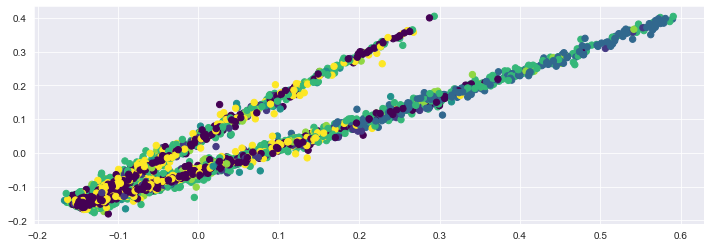

In [276]:
fig = plt.figure(figsize=(12, 4))
plt.scatter(encoder.predict(x)[:, 0], encoder.predict(x)[:, 1], c=labels, s=40, cmap='viridis')

In [277]:
probs = gmm.predict_proba(encoder.predict(x))

In [281]:
print(probs[:5].round(3))

[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [7]:
n_clusters = 7

# Now, adding the clustering layer into the bottelneck layer (just a test with Kmeans)

...Finetuning...


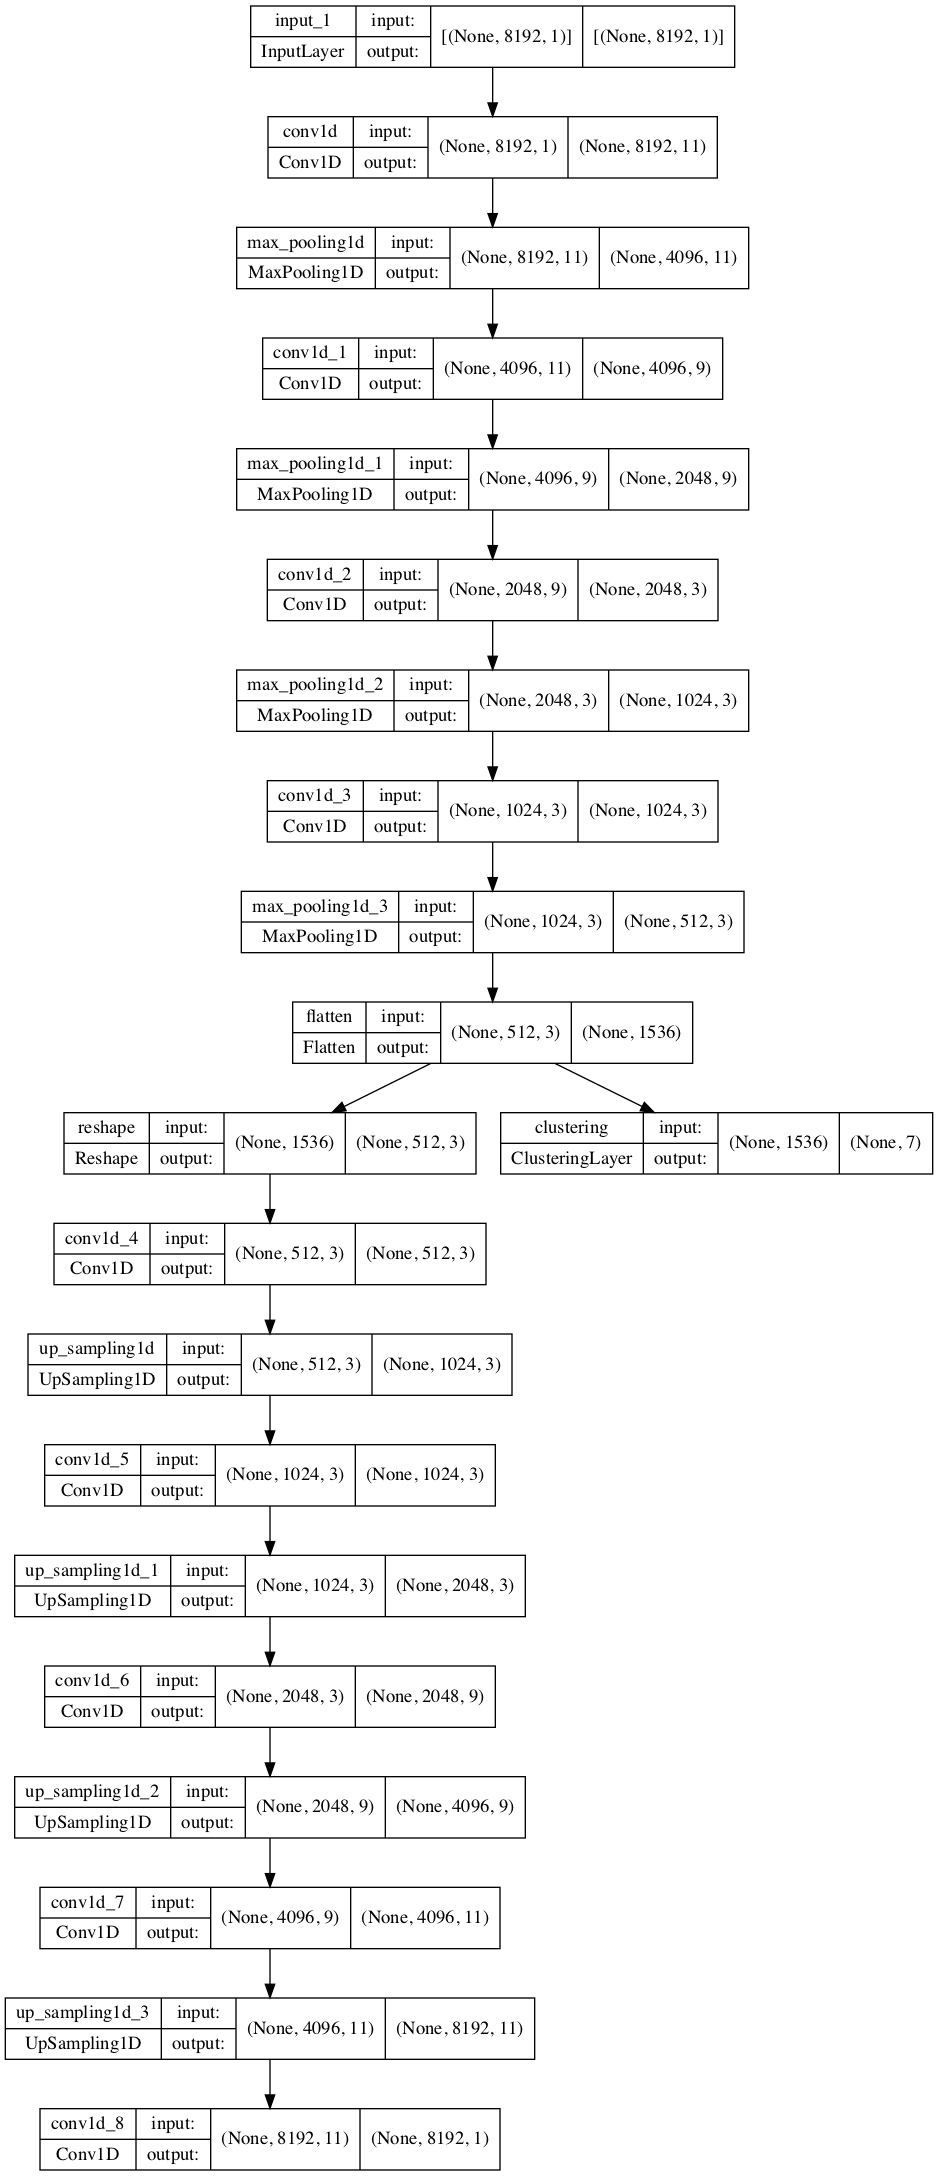

In [8]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

# Finetuning of full network

In [9]:
### initializing the weights using Kmean and assigning them to the model
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

#from scipy.optimize import linear_sum_assignment
#from utils.linear_assignment_ import linear_assignment

#np.round(metrics.acc(y, y_pred), 5)

from sklearn.metrics import silhouette_samples, silhouette_score

cluster_labels = kmeans.fit_predict(encoder.predict(x))
silhouette_avg = silhouette_score(encoder.predict(x), cluster_labels)

In [10]:
## parameters for the finetuning
batch_size=256
tol = 0.001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter =5000
update_interval = 150
index_array = np.arange(x.shape[0])

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        if 1:
            #acc = np.round(metrics.acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            #print('Iter %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)
            print('Iter %d: ' % (ite), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
        
        IN = encoder.predict(x)        
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0  


Iter 0:   ; loss= 0
Iter 150:   ; loss= [6.8812e-01 2.0000e-05 6.8811e-01]
Iter 300:   ; loss= [7.2011e-01 2.5000e-04 7.2009e-01]
Iter 450:   ; loss= [0.67164 0.00201 0.67143]
Iter 600:   ; loss= [0.69126 0.00675 0.69058]
Iter 750:   ; loss= [0.70599 0.00515 0.70547]
Iter 900:   ; loss= [0.68812 0.00563 0.68755]
Iter 1050:   ; loss= [0.68941 0.00746 0.68866]
Iter 1200:   ; loss= [0.73768 0.00381 0.7373 ]
Iter 1350:   ; loss= [0.67152 0.0064  0.67088]
Iter 1500:   ; loss= [0.7163  0.00558 0.71575]
Iter 1650:   ; loss= [0.71992 0.00374 0.71955]
Iter 1800:   ; loss= [0.67526 0.00768 0.67449]
Iter 1950:   ; loss= [0.68689 0.00728 0.68617]
Iter 2100:   ; loss= [0.68055 0.00268 0.68029]
Iter 2250:   ; loss= [0.66644 0.0085  0.66559]
Iter 2400:   ; loss= [0.70412 0.00772 0.70335]
Iter 2550:   ; loss= [0.6545  0.00382 0.65412]
Iter 2700:   ; loss= [0.67097 0.00987 0.66998]
Iter 2850:   ; loss= [0.69079 0.00708 0.69009]
Iter 3000:   ; loss= [0.67344 0.00693 0.67275]
Iter 3150:   ; loss= [0.6745

# Define number of clusters and calculate the Silhoutte Score

For n_clusters = 4 The average silhouette_score is : 0.015058661
For n_clusters = 5 The average silhouette_score is : 0.013691064
For n_clusters = 6 The average silhouette_score is : 0.013133276
For n_clusters = 7 The average silhouette_score is : 0.012684628
For n_clusters = 8 The average silhouette_score is : 0.012646274
For n_clusters = 9 The average silhouette_score is : 0.012636149
For n_clusters = 10 The average silhouette_score is : 0.01205575


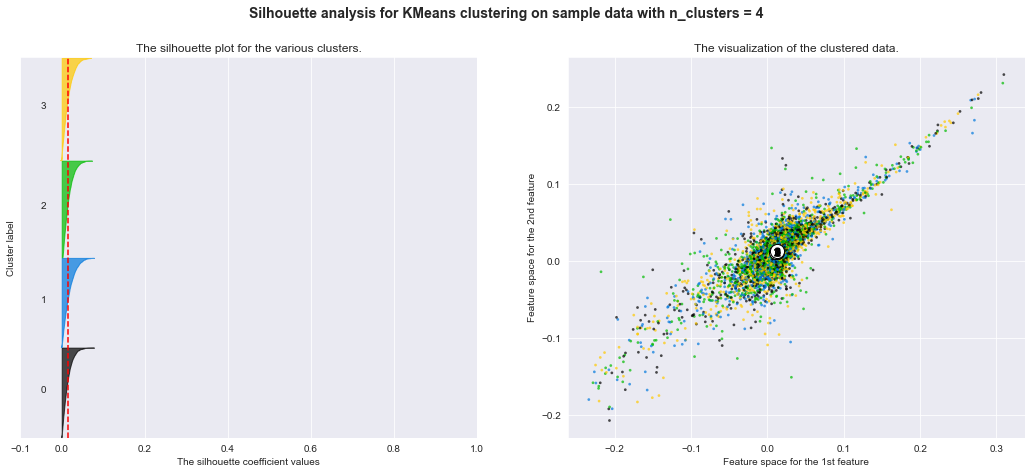

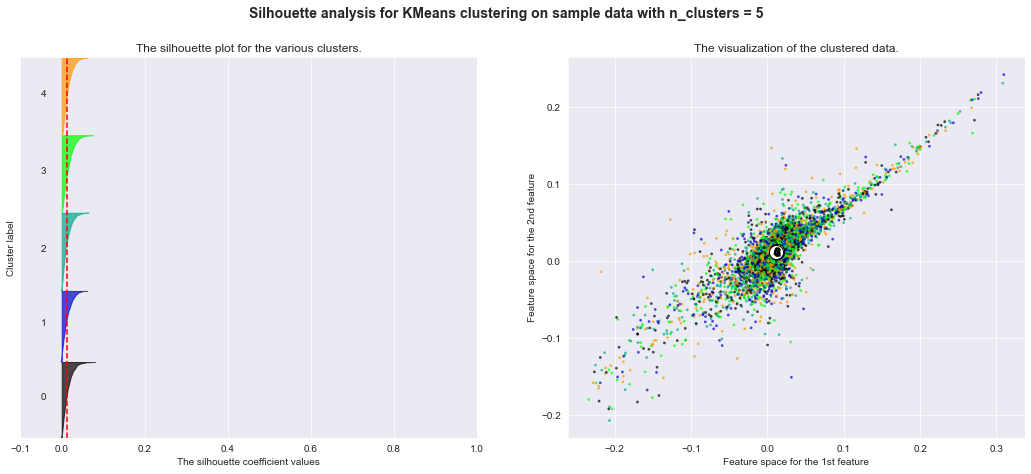

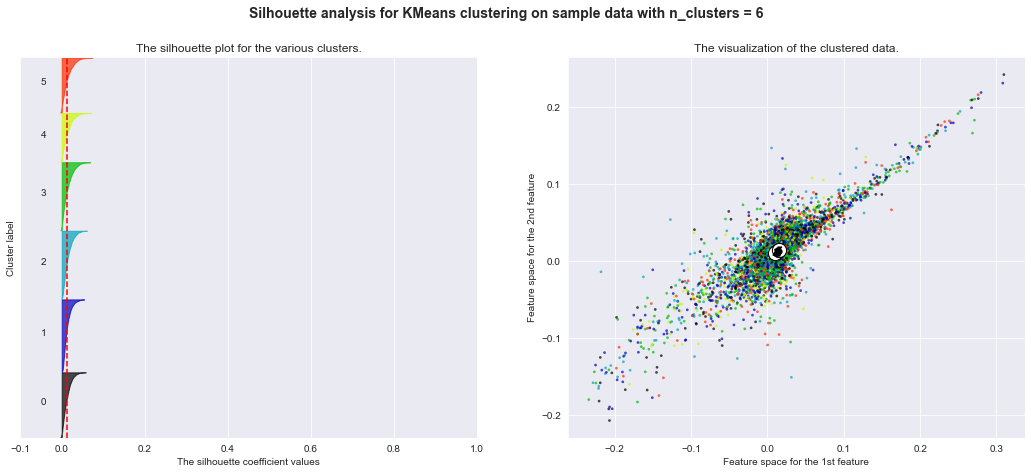

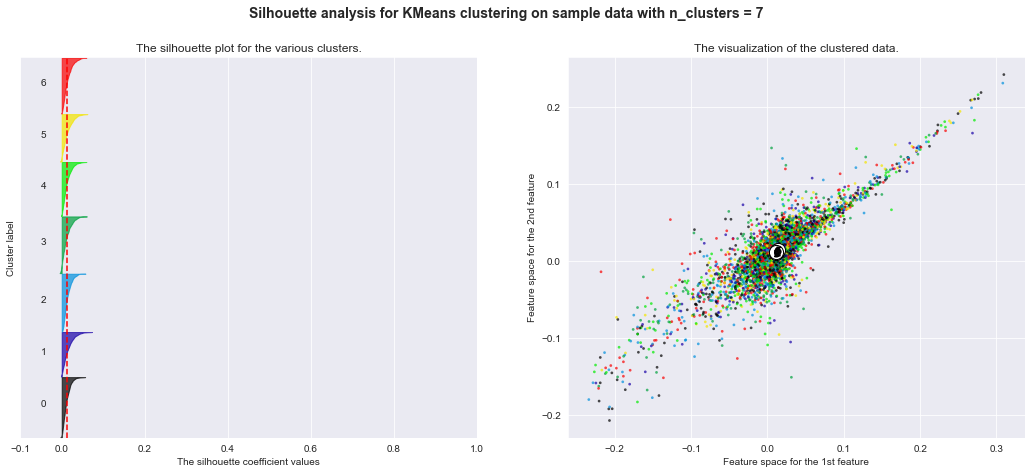

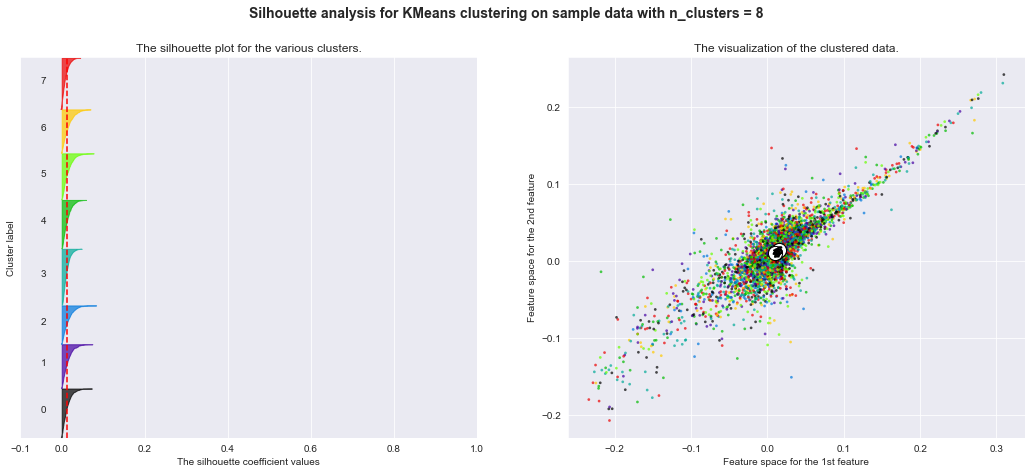

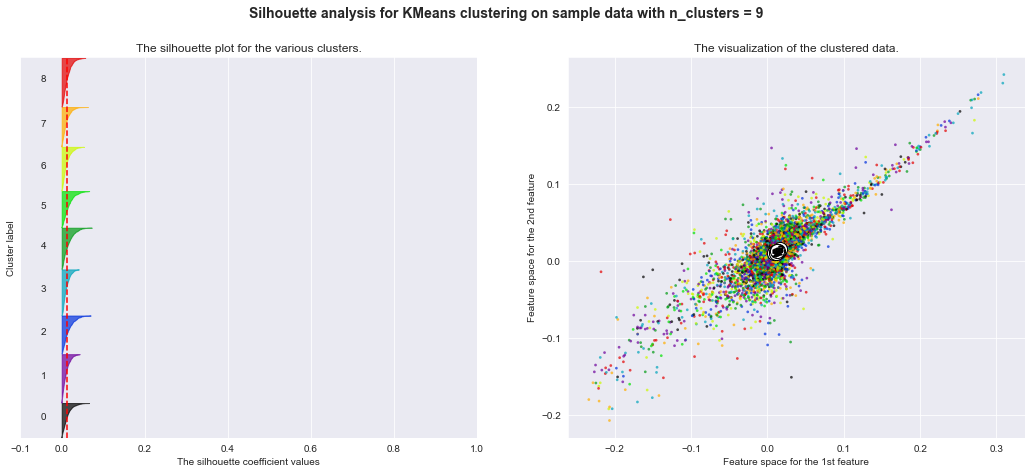

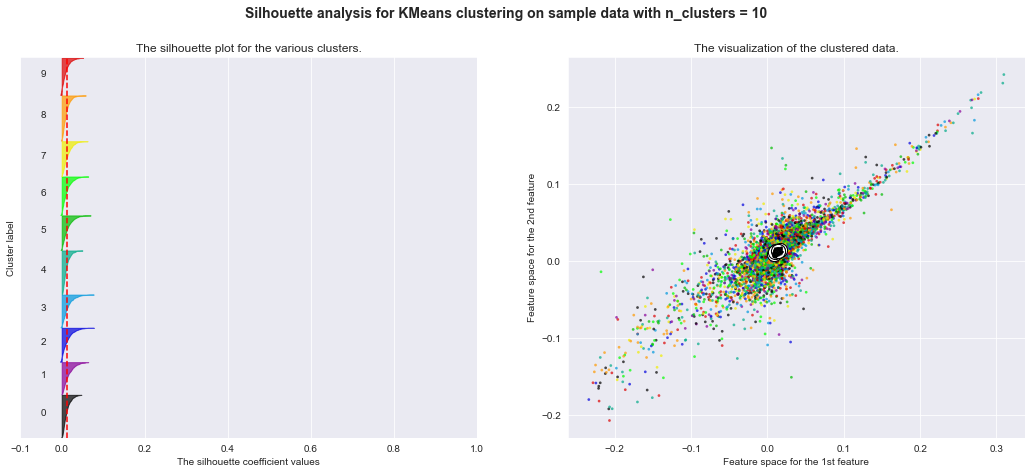

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(encoder.predict(x)) + (n_clusters + 1) * 10])


    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    
    ####cluster_labels = clusterer.fit_predict(x)
    y_pred = kmeans.fit_predict(encoder.predict(x))
    y_pred_last = np.copy(y_pred)
    #model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    cluster_labels = kmeans.fit_predict(encoder.predict(x))
    #####silhouette_avg = silhouette_score(x, cluster_labels)
    silhouette_avg = silhouette_score(encoder.predict(x), cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(encoder.predict(x), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        encoder.predict(x)[:, 0], encoder.predict(x)[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    fig.savefig ( 'kmeancluster-avesil-n='+ str (n_clusters)+'.png', dpi= 100)
plt.show()


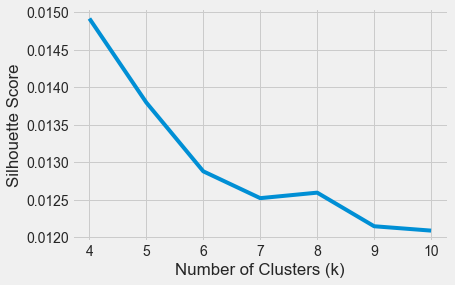

In [12]:
import matplotlib.style as style

range_n_clusters = [4, 5, 6, 7, 8, 9, 10]
score=[]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(encoder.predict(x))
    y_pred_last = np.copy(y_pred)
    cluster_labels = kmeans.fit_predict(encoder.predict(x))
    silhouette_avg = silhouette_score(encoder.predict(x), cluster_labels)
    score.append(silhouette_avg)
style.use("fivethirtyeight")
plt.plot(range_n_clusters, score)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()